# Частотный анализ звуков

In [1]:
%pylab inline
from ipywidgets import interact
from IPython.display import Audio, display


from scipy.signal import hilbert, periodogram, savgol_filter
from scipy.io import wavfile
import warnings
warnings.filterwarnings("ignore", category=wavfile.WavFileWarning)


Populating the interactive namespace from numpy and matplotlib


## 1. Загрузка сигнала из файла

In [2]:
import os

In [3]:
u=os.getcwd()+'\\my_sound\\sinica.wav'
fs,y = wavfile.read(u)
y.shape

(155177, 2)

**Были созданы 2 переменные: fs(частота дискретизации аудиофайла) и у(массив со значениями прочитанного файла)** 

In [4]:
if(y.shape[1]==1):
    print('Это монофоническая запись')
elif(y.shape[1]==2):
    print('Это стереофоническая запись')
else:
    print('Кол-во каналов аудио='+y.shape[1])


Это стереофоническая запись


In [5]:
tmax = y.shape[0]/fs  
print('Мы поделили количество сэмплов в записи на частоту дискретизации и получили длительность записи в секундах='+str(tmax))


Мы поделили количество сэмплов в записи на частоту дискретизации и получили длительность записи в секундах=3.5187528344671204


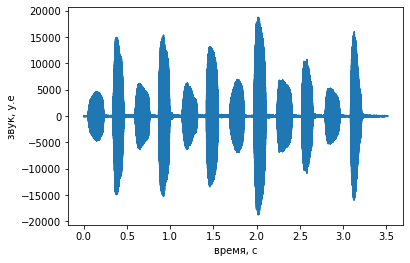

In [6]:
if y.ndim > 1:
    y = y[:,0]

t = arange(len(y))/fs  
plot(t, y);
 
xlabel('время, с');
ylabel('звук, у.е');

На этом фрагменте видно что синица издаёт комплексные звуки, состоящие из двух частей(у первой части комплексного звука амплитуда около 5000, у второй около 15000. У звуков интервал около 0.5с).

In [7]:
Audio(y, rate=fs, autoplay=True)

Вывод: на основании изменения амплитуды колебаний мы можем визуально выделить звуки. На следующем этапе мы сможем выделить 3 вида звуков

## 2. Выделение отдельных звуков

Способ для обнаружения начала и концов амплитудных всплесков, который использует разложение Гильберта в следующем фрагменте кода называется выделением амплитудной составляющей аналитического сигнала(огибающей)


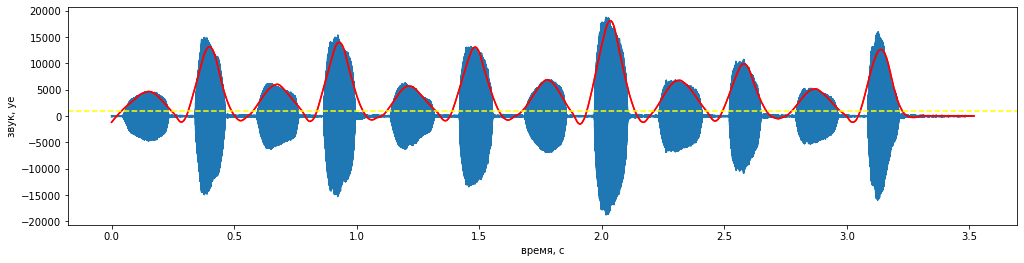

In [8]:
k_sglazh = 8001  
og = savgol_filter(np.abs(hilbert(y)), k_sglazh, 2)

fig, ax = subplots(1,1, figsize=(17,4)) 
plot(t,y, label='сигнал');  
plot(t,og,'r', label='огибающая'); 
porog=1000
plot(t,og,'r', label='огибающая'); 
axhline(porog, color='yellow', label='порог', linestyle='--');

xlabel('время, с');  
ylabel('звук, уе');
   
#xlim(0,2.15)  

Подберём porog, который отсечёт звуки от шума между ними и коэффициент сглаживания, достаточный для чёткого выделения звукав

(array([  1806,  13802,  25485,  36973,  49552,  61315,  73929,  85526,
         97635, 109966, 122436, 134725], dtype=int64),
 array([ 10758,  21579,  34287,  45228,  58324,  69673,  82642,  94161,
        107016, 117792, 131081, 142281], dtype=int64),
 array([202.99319728, 176.34920635, 199.59183673, 187.18820862,
        198.91156463, 189.52380952, 197.57369615, 195.80498866,
        212.72108844, 177.46031746, 196.03174603, 171.33786848]))

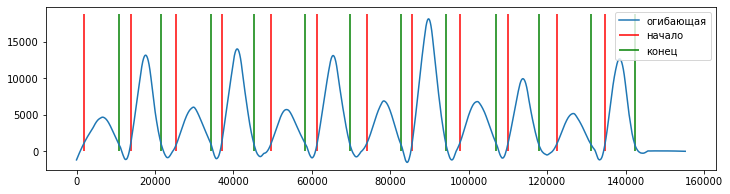

In [9]:

bb = og>porog

iiab = where( diff( bb.astype(int) ) == 1)[0]+1
iiad = where( diff( bb.astype(int) ) == -1)[0]+1


amax = max(y)
figsize(12,3);
plot(og, label='огибающая');
vlines(iiab, 0, amax, color='red', label='начало')
vlines(iiad, 0, amax, color='green', label='конец')
legend();
#xlim(1806, 10758)

dd = (iiad-iiab)/fs * 1000
iiab, iiad, dd


переменные iiab и iiad (индексы) рассчитываются по следующему алгоритму:
1. первое действие - преобразование всех значений массива огибающей выше порога в true(1), а ниже в false(0). Полученный массив для упрощения пояснений назовём arr_1
1. функцией diff вычитаем каждого следующего значения предыдущее. Получаем новый массив(назовём arr_2) на 1 элемент короче так как первый элемент массива arr_1(с индексом 0) не имеет предыдущего значения из которого его можно вычесть. Чтобы получить индекс элемента в arr_1, который вычтя из предыдущего мы определили не равным нулю в arr_2(это индекс начала(1) или конца(-1) звука выше порога), нужно к его index в arr_2 прибавить 1
1. С помощью функции where получим индексы элементов равных 1 в переменную iiab(индексы элементов начала звука) и равных -1 в iiad(соответственно индексы конца звуков)
1. Прибавим единицу к этим индексам чтобы получить индексы в arr_1(так компенсируем смещение индексо из пункта 2)

dd - это длительность в миллисекундах

На данном фрагменте из-за достаточного качества сглаживания дребезга не возникло, и были выбраны именно нужные фрагменты

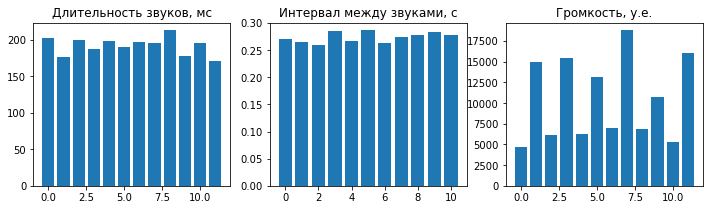

In [10]:
imz = diff(iiab+dd)/fs
a = [max(_x) for i,_x in enumerate(split(y, sort(hstack([iiab,iiad])))) if i%2]
figsize(12,3);
subplot(131)
bar(arange(len(dd)), dd); title('Длительность звуков, мс');
subplot(132)
bar(arange(len(imz)), imz); title('Интервал между звуками, с');
subplot(133)
bar(arange(len(a)), a); title('Громкость, у.е.');

## 3. Спектральный анализ 

При расчете частотных спектров фрагменты сигнала должны иметь некоторую минимальную длительность. Поскольку частота оцифровки звука высока, то данных обычно достаточно даже в очень коротких фрагментах. Параметр `NFFT` (количество компонент при [разложении Фурье](https://ru.wikipedia.org/wiki/Быстрое_преобразование_Фурье)) задает подробность выделения отдельных частотных составляющих. Если данных не хватает, этот параметр можно снизить вдвое или вчетверо.

Построим спектр для каждого из выделенных фрагментов.

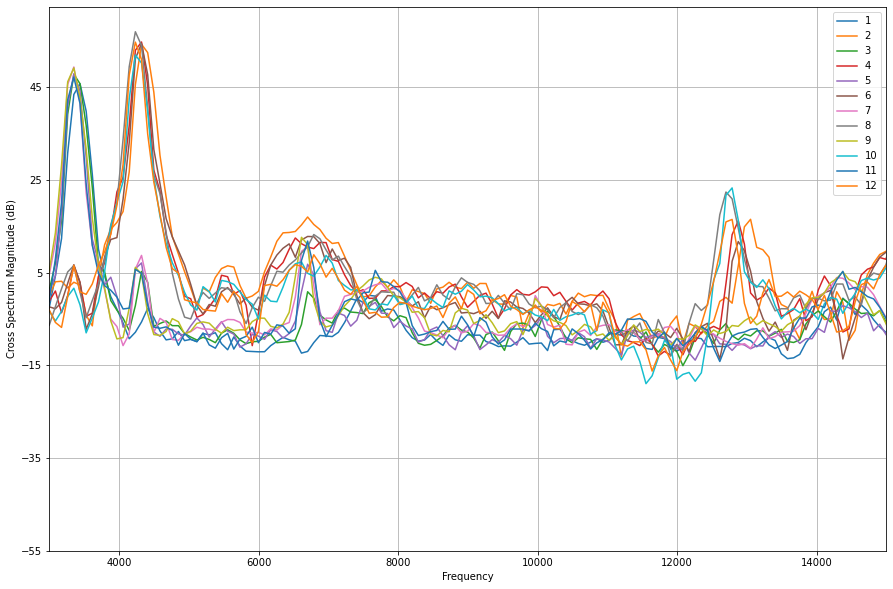

In [11]:
figsize(15,10)
for iab,iad in zip(iiab,iiad):
    y1 = y[iab:iad]
    P, ff = csd(y1, y1, NFFT=500, Fs=fs);
    
legend(arange(len(iiab))+1);
xlim(3000,15000); 

На каждой итерации цикла также будем складывать полученные значения в массив `X`.

Берём по 12000 сэмплов звука
(12, 6024)


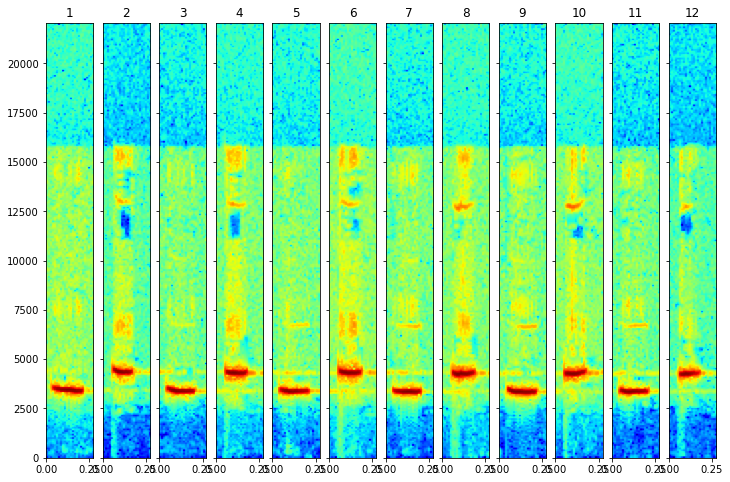

In [14]:
X = []
ddmax=max(dd)/1000*fs
ddmax=round(ddmax//1000+1)*1000
samplesCount=ddmax+2000 
print('Берём по '+ str(samplesCount) +' сэмплов звука')
fig, axx = subplots(1,len(iiab), sharex=True, sharey=True, figsize=(12,8)) 

for i,iab in enumerate(iiab): 
    #y1 = y[iab-1000 : iab+9000]
    y1 = y[iab-1000 : (int)(iab+ddmax+1000)] 
    #В строке выше было решено вместо предлагаемых 9000 сэмплов
    # прибавлять вычисленную максимальную длительность части звука выше порога в сэмплах + тысячу сэмплов  
    # дабы более верно подобрать длину звука 
    
    nftval=500
    sca(axx[i])
    Pxx, freqs, bins, im = specgram(y1, Fs=fs, NFFT=nftval, noverlap=0, cmap='jet');
    
    title(i+1)
    X.append(Pxx.flatten())

X = np.asarray(X)
print(X.shape)

In [15]:
print('Массив X имеет размер '+str(X.shape[0])+' столбцов(соответсвует количеству исследуемых звуков) по  '+str(X.shape[1])+' элементов(это количество зависит от количества входных сэмплов и примерно равно его половине)')

Массив X имеет размер 12 столбцов(соответсвует количеству исследуемых звуков) по  6024 элементов(это количество зависит от количества входных сэмплов и примерно равно его половине)


Наиболее информативна спектрограмма на частотах около 3000-4000гц, примерно во время с 0,01с до 0,21c. На спектрограмме мы видим красную полосу, которая и вляется основной частью нашего звука(при цветовой схеме jet) 

## Сохранение результатов для дальнейшего использования

Сохраним массив значений спектральной плотности для всех выделенных звуков в текстовом формате.


In [16]:
savetxt('spectral_data.txt', X)

Для переноса нескольких переменных в другой блокнот удобно сохранить их в одном сжатом файле. 

In [17]:
savez('для рисунка', og=og, fs=fs, iiab=iiab, iiad=iiad)

# Вывод: 

В ходе работы я научилась выделять отдельные звуки с помощью огибающей, исследовать спектральную составляющую звуков